In [1]:
#!pip install --upgrade pandas
#!pip install --upgrade pandas-datareader

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
#from numba import jit

In [3]:
#punto 1a
sigma = 0.20
#TODO: calibrar con datos historicos

In [4]:

def plain_vanilla_option_price(r, S0, K, T, sigma, op_type="c"):
    "Calculate BS price of call/put"
    d1 = (np.log(S0/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = (np.log(S0/K) + (r - sigma**2/2)*T)/(sigma*np.sqrt(T))
    try:
        if op_type == "c":
            price = S0*norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
        elif op_type == "p":
            price = K*np.exp(-r*T)*norm.cdf(-d2, 0, 1) - S0*norm.cdf(-d1, 0, 1)
        return price
    except:
        print("Please confirm option op_type, either 'c' for Call or 'p' for Put")

In [6]:
def option_delta(r, S0, K, T, sigma, op_type="c"):
    "Calculate BS delta of call/put"
    d1 = ( np.log(S0/K) + (r + sigma**2/2)*T ) / (sigma*np.sqrt(T))
    delta_call = norm.cdf(d1)

    try:
        if op_type == "c":
            delta = delta_call
        elif op_type == "p":
            delta = delta_call - 1
        return delta
    except:
        print("Please confirm option op_type, either 'c' for Call or 'p' for Put")

In [5]:
def contingent_simulation(r,S0,sigma,T,M,j,):    
    simus = []
    t = np.linspace(0,T,j)
    delta_t = t[1]-t[0]
    for i in range (M):  
        S = t.copy()
        S[0] = S0  
        for l in range(1,len(t)):
            S[l] = S[l-1] * np.exp( ( r-0.5*np.power(sigma,2) ) * delta_t + 
                                sigma*np.random.normal(0,np.sqrt(delta_t)))
        simus.append(S)

    return pd.DataFrame(simus)

In [11]:
class option_portfolio:
    def __init__(self,P0,strategy,market, r, K, T, sigma, op_type="c"):

        self.j = market.shape[1] #number of total steps, independent of T
    
        self.r_T = r #rate for units of T real time
        self.r_t = np.power((1+r),1/self.j) - 1 #rate for units of each step of real time
        self.K = K
        self.T = T #real time horizon
        self.sigma = sigma
        self.op_type = op_type
        

        #vector of three: cash, #of calls, #of contingent stock
        self.positions = P0.copy()
        
        #initial implementation will be a string which determines which of
        #the pre implemented strategies will be used
        #implemented strategies: 1.no strategy, 2.delta hedging
        self.strategy = strategy
        #strategy will be a list of zeros and ones of length 3
        
        #this includes the prices of contingencies (rn there is only one)
        #it is a pandas series with dimensions: timesteps X contingencies
        self.market = market.copy()
        
        #list of timestep profit/loss (P/L or PyG )
        self.pyg = [0]

        #time initializes at zero
        #t is the whole counter of delta_time steps
        #delta_time = T/j
        #real_time = t*delta_time = t*T/j
        self.t = 0
        
        #current value of portfolio
        self.value = self.evaluate()

        #save value for analysis
        self.value_history = [self.value]
        

    def buyStock(self,buy):
        #print(buy)
        #print(self.positions)
        #update stock
        self.positions[2] = float(self.positions[2] + buy)
        #update cash
        stock_price = self.market[self.t][0]
        self.positions[0] = float(self.positions[0] - (buy*stock_price))
        #print(self.positions)
        
        
        
    def evaluate(self):
        #value stock and options
        stock_price = float(self.market[self.t][0])
        
        real_time = self.t*self.T/self.j

        opt_price = float(plain_vanilla_option_price(self.r_T, stock_price, self.K,
                      self.T-real_time, self.sigma, self.op_type))
        
        #present cash value of present cash is considered to be always one
        cash_price = 1

        values = np.array([cash_price, opt_price, stock_price])
        #print(values)
        #print(self.positions)

        #value portfolio by multiplying individual values
        #by corresponding quantities
        
        tot_value = np.dot(self.positions,values)

        return tot_value
    
    def delta(self):

        stock_price = float(self.market[self.t][0])
        
        real_time = self.t*self.T/self.j

        n_ops = self.positions[1]
        n_stock = self.positions[2]
        opt_delta = option_delta(self.r_T, stock_price, 
                        self.K, self.T-real_time, self.sigma, self.op_type)
        
        return (n_ops*opt_delta + n_stock)
    
    def advance(self):

        
        #print("antes de cubrir:",self.delta())

        #first of all I make operations today:
        if self.strategy == "no":
            pass
        elif self.strategy == "hedge_delta":
    
            delta_hedge = -(self.delta())

            self.buyStock(delta_hedge)
        
        #advance into the future
        self.t = self.t + 1

        #update cash account:
        self.positions[0] = self.positions[0]*(1 + self.r_t)

        #next day:

        #evaluate today 
        new_value = self.evaluate()
        #calculate PL
        PL_t = new_value - self.value
        #save PL
        self.pyg.append(PL_t)
        #update saved value
        self.value = new_value

        self.value_history.append(new_value)
        
    def play(self):
        if self.t==self.j-1:
            print("already played")
        else:
            for i in range(self.j-1):
                self.advance()
      

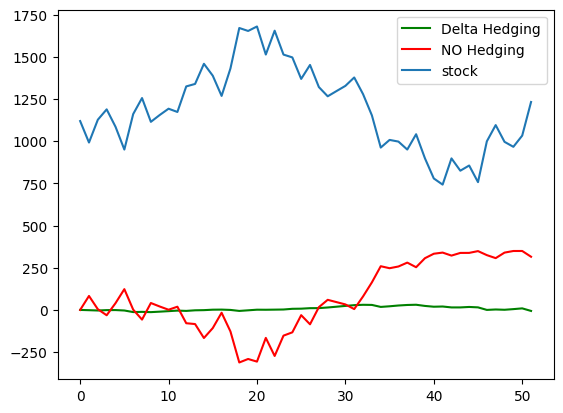

In [23]:
#simular uno solo:
r = 13.25/100
S0 = 1120
K = 1250
T = 1

sigma = 0.7

j=52

#P0 = [0,-1,0]
P0 = [plain_vanilla_option_price(r,S0,K,T,sigma,"c"),-1,0]
market1 = contingent_simulation(r,S0,sigma,T,1,j)
p = option_portfolio(P0,"hedge_delta",market1, r, K, T, sigma, op_type="c")
p.play()
p2 = option_portfolio(P0,"no",market1, r, K, T, sigma, op_type="c")
p2.play()
#print(sum(p.pyg))
plt.plot(p.value_history,color="green",label="Delta Hedging")
plt.plot(p2.value_history,color="red",label="NO Hedging")
market1.iloc[0,:].plot(label="stock")
plt.legend()
plt.show()

#plt.show()
